In [2]:
import skimage
import cv2
from IPython import display
import matplotlib.pyplot as plt
from scipy import stats as stats
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
plt.style.use('seaborn-v0_8')

In [ ]:
# Opnemen video
cam = cv2.VideoCapture(0)

video = []

i=0
while i<600: # Maak een opname van 600 frames
    i+=1
    check, frame = cam.read()
    video.append(frame) # Python arrays zijn langzaam, maar dit is in ieder geval duidelijk

video = np.array(video)
video = skimage.color.rgb2gray(video) # RGB -> grayscale

cam.release()
cv2.destroyAllWindows()

In [ ]:
# Bekijken van de video
fig = plt.figure()

imgs = []
for i,frame in enumerate(video):
    display.clear_output(wait=True)
    plt.title(r"frame %s" % i)
    plt.imshow(frame, cmap=plt.cm.gray)
    plt.show()

In [ ]:
# Totale intensiteit van de video
intensities = []
for frame in video:
    intensities.append(frame.sum())

# Opslaan van data in CSV-bestanden
a = np.array(intensities)
df = pd.DataFrame(a)
df.to_csv("naam-CSV-bestand.csv.", header=False, index=False)

plt.plot(intensities, '.-', color='black')
plt.xlabel(r"Frame [-]")
plt.ylabel(r"Intensiteit [a.u.]")
plt.grid()

In [3]:
def data_analyse(data):
    gemiddelde = np.mean(data, axis=0)
    stdv = np.std(data, ddof=1)
    alpha = 0.05
    vrijheidsgraden = len(data) - 1
    t = stats.t.ppf(1 - alpha/2, vrijheidsgraden)
    betrouwbaarheid = (t*stdv)/np.sqrt(len(data))
    return print('Gemiddelde golflengte onbekende lamp = '
                 f'{gemiddelde} ± {betrouwbaarheid}')

In [4]:
# Definiëren lineair functie
def lineaire_functie(frames, a, b):
    golflengte = a*frames + b
    return golflengte

In [5]:
# Bekende golflengtes
class LEDlamp:
    golflengte_blauw = 4.50e-7
    golflengte_groen = 5.30e-7
    golflengte_rood = 6.60e-7

class Kwiklamp:
    golflengte_geel = 5.78e-7
    golflengte_groen = 5.46e-7
    golflengte_paars = 4.34e-7

In [6]:
# Uitlezen van alle metingen
LED_meting1 = np.loadtxt("output 1.csv", delimiter=',')
LED_meting2 = np.loadtxt("output 2.csv", delimiter=',')
LED_meting3 = np.loadtxt("output 3.csv", delimiter=',')

Kwik_meting1 = np.loadtxt("output 3A.csv", delimiter=',')
Kwik_meting2 = np.loadtxt("output 4A.csv", delimiter=',')

onbekende_lamp1 = np.loadtxt("output O1.csv", delimiter=',')
onbekende_lamp2 = np.loadtxt("output 10.csv", delimiter=',')

In [7]:
# Vinden pieken van alle metingen
golflengtes_LED_meting1 = find_peaks(LED_meting1, height=500)[0]
golflengtes_LED_meting2 = find_peaks(LED_meting2, height=500)[0]
golflengtes_LED_meting3 = find_peaks(LED_meting3, height=500)[0]


golflengtes_Kwik_meting1 = find_peaks(Kwik_meting1, height=500)[0]

golflengtes_Kwik_meting2 = find_peaks(Kwik_meting2, height=500)[0]
golflengtes_Kwik_meting2 = np.delete(golflengtes_Kwik_meting2, 0)

golflengtes_Kwik_meting3 = np.append(golflengtes_Kwik_meting1, golflengtes_Kwik_meting2)

golflengtes_onbekende_lamp1 = find_peaks(onbekende_lamp1, height=5000)[0]
golflengtes_onbekende_lamp2 = find_peaks(onbekende_lamp2, height=5000)[0]

In [8]:
# Berekenen constanten (a en b) fit vergelijking
frames = np.linspace(0, 250, num=1000)
x1 = np.array(golflengtes_Kwik_meting3)
y1 = np.array([Kwiklamp.golflengte_paars, Kwiklamp.golflengte_paars, Kwiklamp.golflengte_groen, Kwiklamp.golflengte_groen, Kwiklamp.golflengte_geel, Kwiklamp.golflengte_geel])
een_vec = np.ones_like(x1)
A = np.array([x1, een_vec])
A = A.transpose()
[a, b] = np.linalg.solve(A.transpose() @ A, A.transpose() @ y1)

In [9]:
# Maken van de ijklijn
ijklijn = lineaire_functie(frames, a, b)

In [10]:
# Berekenen van de foutmarge
o1 = lineaire_functie(golflengtes_LED_meting1[0], a, b)
o2 = lineaire_functie(golflengtes_LED_meting1[1], a, b)

o3 = lineaire_functie(golflengtes_LED_meting2[0], a, b)
o4 = lineaire_functie(golflengtes_LED_meting2[1], a, b)

o5 = lineaire_functie(golflengtes_LED_meting3[0], a, b)
o6 = lineaire_functie(golflengtes_LED_meting3[1], a, b)


q1 = np.abs(LEDlamp.golflengte_blauw - o1)
q2 = np.abs(LEDlamp.golflengte_groen - o2)

q3 = np.abs(LEDlamp.golflengte_blauw - o3)
q4 = np.abs(LEDlamp.golflengte_groen - o4)

q5 = np.abs(LEDlamp.golflengte_blauw - o5)
q6 = np.abs(LEDlamp.golflengte_groen - o6)


q7 = np.array([q1, q2, q3, q4, q5, q6])
q7 = np.mean(q7)
q7

1.4000858640636217e-08

In [13]:
# Berekenen golflengte van de onbekende lamp
onbekende_golflengte1 = lineaire_functie(golflengtes_onbekende_lamp1[0], a, b)
onbekende_golflengte2 = lineaire_functie(golflengtes_onbekende_lamp2[0], a, b)
onbekende_golflengte = np.array([onbekende_golflengte1, onbekende_golflengte2])
data_analyse(onbekende_golflengte)

Gemiddelde golflengte onbekende lamp = 5.164590563991323e-07 ± 0.0


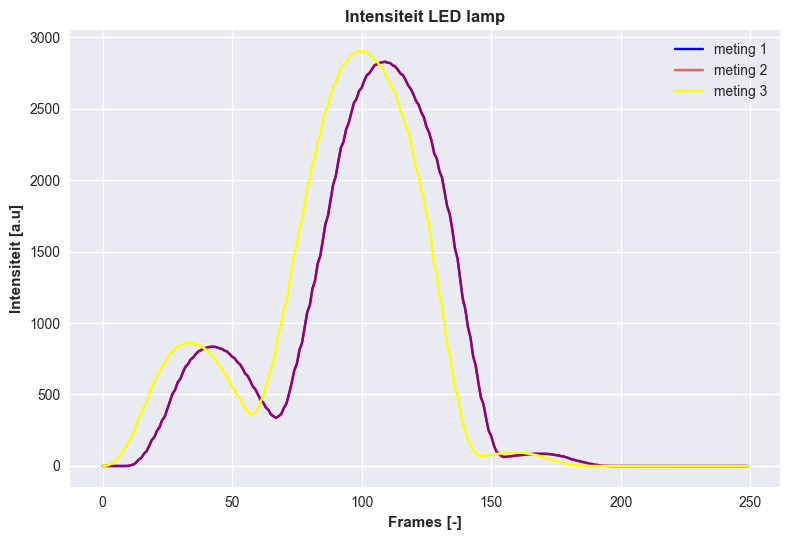

In [14]:
# Plotten van alle figuren
fig1 = plt.figure()
plt.plot(LED_meting1, color='blue', label='meting 1')
plt.plot(LED_meting2, color='red', label='meting 2', alpha=0.6)
plt.plot(LED_meting3, color='yellow', label='meting 3')
plt.xlabel('Frames [-]', weight='bold')
plt.ylabel('Intensiteit [a.u]', weight='bold')
plt.title("Intensiteit LED lamp", weight='bold')
plt.legend()
plt.tight_layout()

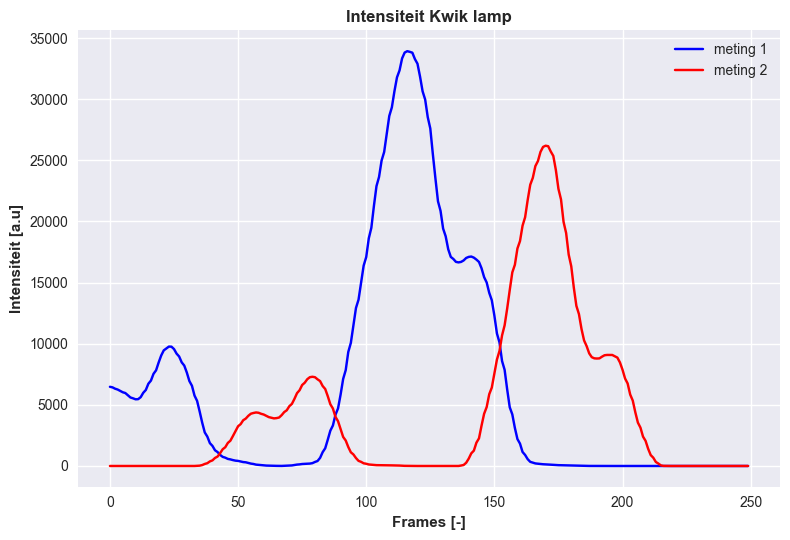

In [15]:
fig2 = plt.figure()
plt.plot(Kwik_meting1, color='blue', label='meting 1')
plt.plot(Kwik_meting2, color='red', label='meting 2')
plt.xlabel('Frames [-]', weight='bold')
plt.ylabel('Intensiteit [a.u]', weight='bold')
plt.title("Intensiteit Kwik lamp", weight='bold')
plt.legend()
plt.tight_layout()

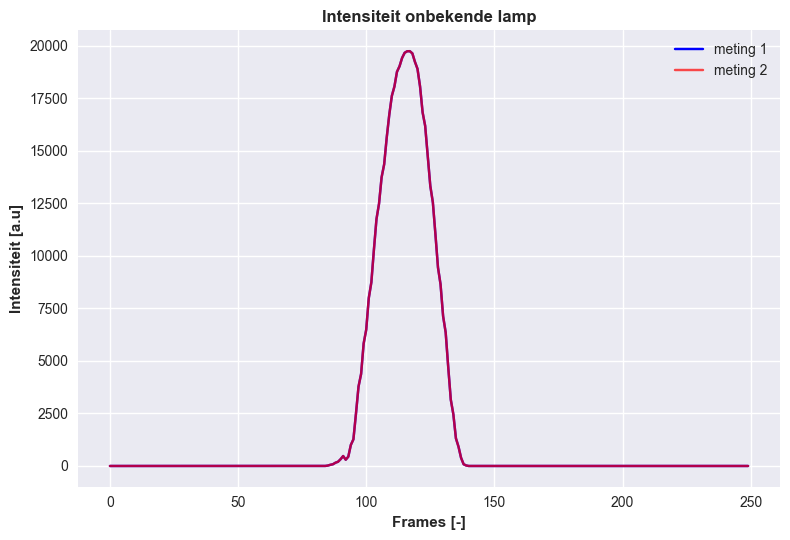

In [16]:
fig3 = plt.figure()
plt.plot(onbekende_lamp1, color='blue', label='meting 1')
plt.plot(onbekende_lamp2, color='red', label='meting 2', alpha=0.7)
plt.xlabel('Frames [-]', weight='bold')
plt.ylabel('Intensiteit [a.u]', weight='bold')
plt.title("Intensiteit onbekende lamp", weight='bold')
plt.legend()
plt.tight_layout()

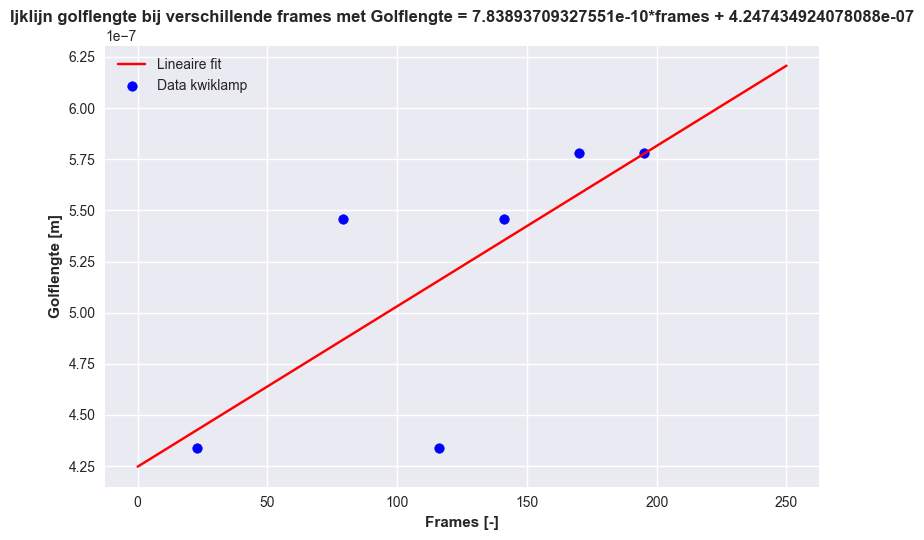

In [17]:
fig4 = plt.figure()
plt.plot(frames, ijklijn, color='red', label='Lineaire fit')
plt.scatter(x1, y1, color='blue', label='Data kwiklamp')
plt.xlabel('Frames [-]', weight='bold')
plt.ylabel('Golflengte [m]', weight='bold')
plt.title(f"Ijklijn golflengte bij verschillende frames met Golflengte = {a}*frames + {b}", weight='bold')
plt.legend()
plt.tight_layout()